In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
import shap
shap.initjs()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('data.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_109,Feature_110,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118
0,1,2,2,56,12,1,7.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,1,1,0
1,2,2,2,69,19,1,6.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,1
2,3,2,1,66,8,1,4.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0
3,4,2,2,62,16,1,NaN,3,0,1.0,...,1.0,0.0,1,0,1,1,0,0,1,1
4,5,2,2,67,30,1,NaN,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0


In [5]:
def train(df, trash_features = [], drop_susp_features = True):

    df_ = df.copy()

    target_feature = 'Result'
    usefull_features = ['Feature_7', 'Feature_15', 'Feature_40', 'Feature_73', 'Feature_109', 'Feature_110', 
                        'Feature_111', 'Feature_112','Feature_113','Feature_114','Feature_115']
    useless_features = ['Id', 'Feature_3', 'Feature_4', 'Feature_35', 'Feature_17', 'Feature_18', 'Feature_22', 
                        'Feature_23', 'Feature_54', 'Feature_94', 'Feature_108', 'Feature_116', 'Feature_117']
    susp_features = ['Feature_29', 'Feature_30', 'Feature_32', 'Feature_101']

    features_to_drop = [target_feature] + useless_features
    for feature in trash_features:
        if feature not in usefull_features and feature not in useless_features:
            features_to_drop.append(feature)

    if drop_susp_features is True:
        features_to_drop += susp_features

    all_features = df_.columns.drop(features_to_drop).tolist()

    df_ = df_[[target_feature] + all_features]

    num_features = ['Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46',
                'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_53', 'Feature_55', 'Feature_57', 
                'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 'Feature_71', 'Feature_72', 'Feature_73']
    
    special_features = ['Feature_17', 'Feature_18', 'Feature_23', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 
                    'Feature_79', 'Feature_80', 'Feature_81', 'Feature_82', 'Feature_83', 'Feature_84', 'Feature_85', 'Feature_86', 'Feature_87', 
                    'Feature_88', 'Feature_89', 'Feature_90', 'Feature_91', 'Feature_92', 'Feature_93', 'Feature_94', 'Feature_95', 'Feature_96', 
                    'Feature_97', 'Feature_98', 'Feature_99', 'Feature_100']
    for col in special_features:
        if col in df_.columns:
            df_[col].fillna(0, inplace=True)

    cat_features = []
    for col in df_.drop(target_feature, axis=1).columns:
        if col in num_features:
            df_[col].fillna(df_[col].median(), inplace=True)
            df_[col] = df_[col].astype('float64')
        else:
            cat_features.append(col)

            df_[col].fillna(-1, inplace=True)
            df_[col] = df_[col].astype('int64')
    
    # Result=0 - alive, Result=1 died
    df_.loc[df_[target_feature] == 1, target_feature] = 0
    df_.loc[df_[target_feature] == 2, target_feature] = 1

    X = df_[all_features]
    y = df_[target_feature]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=True,
        test_size=0.25,
        random_state=0,
        stratify=y,
    )

    train_pool = Pool(
        X_train,
        y_train,
        cat_features=cat_features
    )

    params_frozen = {
        'eval_metric': 'Accuracy',
        'early_stopping_rounds': 50,
    }

    params_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'iterations': [100, 200, 400, 600, 800, 1000, 1200],
        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
        'bagging_temperature': [1, 1.5, 2, 2.5],
    }

    clf = CatBoostClassifier(**params_frozen)
    rs = clf.randomized_search(
        params_grid,
        train_pool,
        n_iter=5,
        shuffle=True,
        stratified=True,
        partition_random_seed=0,
        cv=5,
        calc_cv_statistics=True,
        search_by_train_test_split=False,
        refit=True,
    )

    return clf, df_, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature

In [10]:
trash_features = []
epochs = 5
for epoch in range(1, epochs+1):

    print(f"\nEpoch {epoch} from {epochs}\n{'=' * 50}")

    clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
        df_init,
        trash_features=trash_features,
        drop_susp_features=True,
    )

    test_pool = Pool(
        X_test,
        y_test,
        cat_features=cat_features
    )
    y_test_pred = clf.predict(test_pool)

    print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
    print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

    feature_importances = pd.DataFrame(
        zip(X_train.columns, clf.get_feature_importance()),
        columns=['feature_name', 'importance']
    )

    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    features = feature_importances[feature_importances['importance'] < 1 ]['feature_name'].tolist()
    if len(trash_features) > 0:
        for feature in features:
            if feature not in trash_features:
                trash_features.append(feature)
    else:
        trash_features=features

    print('Fetures to drop')
    print(trash_features)


Epoch 1 from 5
Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.7741991	best: 0.7741991 (0)	total: 1m 18s	remaining: 5m 14s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.7637662	best: 0.7741991 (0)	total: 2m 23s	remaining: 3m 35s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.7919481	best: 0.7919481 (2)	total: 2m 52s	remaining: 1m 54s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.7096970	best: 0.7919481 (2)	total: 4m 13s	remaining: 1m 3s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.7464935	best: 0.7919481 (2)	total: 5m 47s	remaining: 0us
Accuracy: 0.83
F1 Score: 0.88

Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.85      0.92      0.88        25

    accuracy                           0.83        36
   macro avg       0.81      0.78      0.79        36
weighted avg       0.83      0.83   

In [16]:
trash_features = ['Feature_60', 'Feature_95', 'Feature_80', 'Feature_115', 'Feature_61', 'Feature_40', 'Feature_55', 'Feature_48', 
                    'Feature_96', 'Feature_58', 'Feature_66', 'Feature_24', 'Feature_64', 'Feature_43', 'Feature_86', 'Feature_65', 
                    'Feature_111', 'Feature_81', 'Feature_2', 'Feature_113', 'Feature_77', 'Feature_106', 'Feature_67', 'Feature_73', 
                    'Feature_78', 'Feature_31', 'Feature_10', 'Feature_8', 'Feature_114', 'Feature_92', 'Feature_72', 'Feature_51', 
                    'Feature_112', 'Feature_118', 'Feature_69', 'Feature_7', 'Feature_107', 'Feature_50', 'Feature_1', 'Feature_110', 
                    'Feature_109', 'Feature_25', 'Feature_76', 'Feature_12', 'Feature_83', 'Feature_88', 'Feature_11', 'Feature_19', 
                    'Feature_100', 'Feature_16', 'Feature_62', 'Feature_97', 'Feature_15', 'Feature_13', 'Feature_75', 'Feature_98', 
                    'Feature_21', 'Feature_20', 'Feature_38', 'Feature_93', 'Feature_74', 'Feature_90', 'Feature_89', 'Feature_87', 
                    'Feature_26', 'Feature_85', 'Feature_27', 'Feature_33', 'Feature_36', 'Feature_37', 'Feature_91', 'Feature_59', 
                    'Feature_14', 'Feature_53', 'Feature_82', 'Feature_45']

clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
    df_init,
    trash_features=trash_features,
    drop_susp_features=True,
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features
)
y_test_pred = clf.predict(test_pool)
y_test_pred_proba = clf.predict_proba(test_pool)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.8119048	best: 0.8119048 (0)	total: 30.1s	remaining: 2m
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.8023810	best: 0.8119048 (0)	total: 1m 1s	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.7723810	best: 0.8119048 (0)	total: 1m 43s	remaining: 1m 9s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.8023810	best: 0.8119048 (0)	total: 2m 57s	remaining: 44.3s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.7369697	best: 0.8119048 (0)	total: 4m 9s	remaining: 0us
Accuracy: 0.86
F1 Score: 0.9

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.88      0.92      0.90        25

    accuracy                           0.86        36
   macro avg       0.84      0.82      0.83        36
weighted avg       0.86      0.86      0.86        36



In [8]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
9,Feature_41,10.931899
6,Feature_34,8.274062
25,Feature_99,7.029663
20,Feature_70,6.560538
16,Feature_56,6.123949
0,Feature_5,5.194931
10,Feature_42,4.963046
18,Feature_63,4.667751
21,Feature_71,4.301021
3,Feature_9,4.126860


In [12]:
explainer = shap.TreeExplainer(clf)
shap_values_train = explainer.shap_values(X_train)

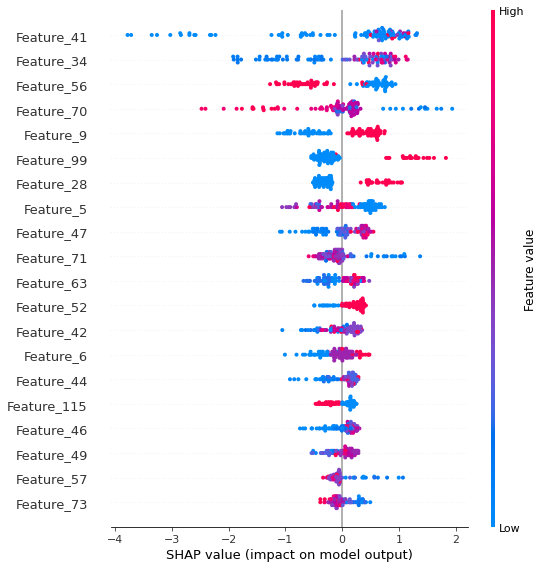

In [13]:
shap.summary_plot(shap_values_train, X_train)

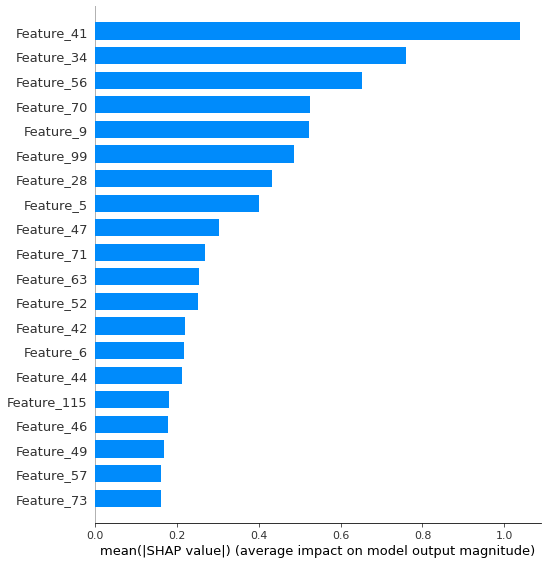

In [14]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar")

In [17]:
df_explain = X_test.copy()
df_explain['Result_true'] = y_test
df_explain['Result_pred'] = y_test_pred
df_explain['Result_pred_proba'] = y_test_pred_proba[:, 1:2]

In [18]:
df_errors = df_explain[df_explain['Result_true'] != df_explain['Result_pred']]
shap_values_test = explainer.shap_values(df_errors)

df_errors.T

,4,134,140,35,104
Feature_5,-1.000000,-1.000000,4.000000,2.000000,5.000000
Feature_6,4.000000,2.000000,2.000000,2.000000,3.000000
Feature_7,0.000000,0.000000,0.000000,0.000000,0.000000
Feature_9,1.000000,-1.000000,0.000000,0.000000,1.000000
Feature_15,0.000000,-1.000000,0.000000,0.000000,0.000000
Feature_28,0.000000,0.000000,0.000000,0.000000,0.000000
Feature_34,12.000000,3.000000,1.000000,9.000000,9.000000
Feature_39,122.600000,166.900000,127.000000,133.000000,144.200000
Feature_40,20.000000,2.060000,1.600000,0.490000,2.320000
Feature_41,0.007000,0.060000,0.060000,0.020000,0.080000


In [19]:
shap.force_plot(explainer.expected_value, shap_values_test[0,:], df_errors.iloc[0,:])

In [20]:
shap.force_plot(explainer.expected_value, shap_values_test[1,:], df_errors.iloc[1,:])

In [21]:
shap.force_plot(explainer.expected_value, shap_values_test[2,:], df_errors.iloc[2,:])

In [22]:
shap.force_plot(explainer.expected_value, shap_values_test[3,:], df_errors.iloc[3,:])

In [23]:
shap.force_plot(explainer.expected_value, shap_values_test[4,:], df_errors.iloc[4,:])